<a href="https://colab.research.google.com/github/junanda/collaborative-filtering/blob/main/Recommedation_Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommendation Movie using Collaborative Filtering**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

Load data

In [2]:
movie_file_url = ("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
movie_zipped_file = keras.utils.get_file("ml-latest-small.zip", movie_file_url, extract=False)
keras_datasets_path = Path(movie_zipped_file).parents[0]
movie_dir = keras_datasets_path / "ml-latest-small"

# Only extract teh data the first time the script in run.
if not movie_dir.exists():
    with ZipFile(movie_zipped_file, "r") as zip:
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done......")

ratings_file = movie_dir / "ratings.csv"

df_data = pd.read_csv(ratings_file)

983040/978202 [==============================] - 1s 1us/step
Extracting all the files now...
Done......


In [19]:
df_data.head()

,userId,movieId,rating,timestamp,user,movie
66674,429,195,4.0,828124616,428,543
79937,500,1148,4.0,1005528205,499,1099
98086,606,5614,4.5,1171404629,605,9463
53636,354,1214,4.0,1200870323,353,75
42812,288,3672,3.0,978468053,287,6001


Preprocessing to encode users and movies as integer indices

In [3]:
user_ids = df_data["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df_data["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df_data["user"] = df_data["userId"].map(user2user_encoded)
df_data["movie"] = df_data["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df_data["rating"] = df_data["rating"].values.astype(np.float32)

min_rating = min(df_data["rating"])
max_rating = max(df_data["rating"])

print("Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(num_users, num_movies, min_rating, max_rating))

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


Prepare data training and validation

In [6]:
df_data = df_data.sample(frac=1, random_state=42)
x = df_data[["user", "movie"]].values
# Normalize the targets between 0 and 1
y = df_data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# training 80% and validation 20%
train_indices = int(0.8 * df_data.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# Create Model
 embbed both users and movies in to 50-dimentional vectors

 The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [12]:
EMBEDDING_SIZE = 50

class Recommender(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(Recommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users, embedding_size, embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
    
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # add all components include (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [13]:
model = Recommender(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

Train the model based on the data split

In [32]:
resultx = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1261/1261 [==============================] - 6s 5ms/step - loss: 0.6070 - val_loss: 0.6154
Epoch 2/5
1261/1261 [==============================] - 6s 5ms/step - loss: 0.6053 - val_loss: 0.6162
Epoch 3/5
1261/1261 [==============================] - 6s 5ms/step - loss: 0.6072 - val_loss: 0.6168
Epoch 4/5
1261/1261 [==============================] - 6s 5ms/step - loss: 0.6057 - val_loss: 0.6173
Epoch 5/5
1261/1261 [==============================] - 6s 5ms/step - loss: 0.6060 - val_loss: 0.6169


Plot training and validation loss

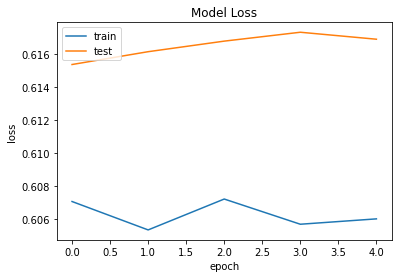

In [33]:
%matplotlib inline

plt.plot(resultx.history["loss"])
plt.plot(resultx.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Show top 10 movie recommendations to a user

In [17]:
movie_df = pd.read_csv(movie_dir / "movies.csv")
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [34]:
# get user and see the top recommendation
user_id = df_data.userId.sample(1).iloc[0]
movie_watched_by_user = df_data[df_data.userId == user_id]
movies_not_watched = movie_df[
                              ~movie_df["movieId"].isin(movie_watched_by_user.movieId.values)
                              ]["movieId"]
movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indicies = ratings.argsort()[-10:][::-1]
recommended_movies_ids = [
      movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indicies
]

print("Showing recommendations for user: {}".format(user_id))
print("+++++" * 9)
print("Movies with hight ratings from user")
print("-----" * 9)
top_movies_user = (
    movie_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values
)

movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, " : ", row.genres)

print("-----" * 9)
print("Top 10 movie recommendations")
print("-----" * 9)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movies_ids)]
for row in recommended_movies.itertuples():
    print(row.title, " : ", row.genres)

Showing recommendations for user: 274
+++++++++++++++++++++++++++++++++++++++++++++
Movies with hight ratings from user
---------------------------------------------
American Beauty (1999)  :  Drama|Romance
American Psycho (2000)  :  Crime|Horror|Mystery|Thriller
Kill Bill: Vol. 1 (2003)  :  Action|Crime|Thriller
Kill Bill: Vol. 2 (2004)  :  Action|Drama|Thriller
Hot Fuzz (2007)  :  Action|Comedy|Crime|Mystery
---------------------------------------------
Top 10 movie recommendations
---------------------------------------------
Lamerica (1994)  :  Adventure|Drama
Heidi Fleiss: Hollywood Madam (1995)  :  Documentary
Children of the Corn IV: The Gathering (1996)  :  Horror
Autumn Sonata (Höstsonaten) (1978)  :  Drama
Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975)  :  Comedy|Drama
Trial, The (Procès, Le) (1962)  :  Drama
Hunger (2008)  :  Drama
Enter the Void (2009)  :  Drama
Lincoln (2012)  :  Drama|War
Three Billboards Outside Ebbing, Missouri (2017)  : 